In [11]:
from dataclasses import dataclass
from datetime import datetime, timedelta
from typing import Any
from unittest.mock import patch

import graphviz
from energy_box_control.control.state_machines import OR, AND, BooleanOpPredicate, Marker, NegatePredicate, Predicate, StateMachine, TimedPredicate, Value, WithinPredicate
from energy_box_control.power_hub.control.hot.control import hot_control_state_machine
from energy_box_control.power_hub.control.hot.state import HotControlMode
from energy_box_control.power_hub.control.state import Fn, Setpoints, initial_control_state


@dataclass
class State:
  name: str

@dataclass
class Transition:
  condition: str
  origin: State
  dest: State

setpoint = initial_control_state().setpoints

class Tracker:
    def __init__(self, so_far: str = ""):
        self._so_far = so_far

    def __call__(self, *args):
       if self._so_far.endswith("in_position"):
          return f"{self._so_far.removesuffix(".in_position")} in position"

    def __getitem__(self, item):
        return Tracker(f"{self._so_far}.{item}")

    def __getattr__(self, item):
        if self._so_far.startswith("control_state.setpoints"):
          val = getattr(setpoint, item)
          if not isinstance(val, datetime):
            return getattr(setpoint, item)
        return Tracker(f"{self._so_far}.{item}")

    def __gt__(self, other):
      return self._op(other, ">")
    
    def __lt__(self, other):
       return self._op(other, "<")
    
    def __eq__(self, other):
       return self._op(other, "==")

    def __ne__(self, other):
       return self._op(other, "!=")

    def _op(self, other, op):
        match other:
            case x if isinstance(x, Predicate):
                return Tracker(f"{self._so_far} {op} {predicate_to_string(x)}")
            case x if isinstance(x, Tracker):
                return Tracker(f"{self._so_far} {op} {x.result}")
            case x:
                return Tracker(f"{self._so_far} {op} {str(x)}")

    @property
    def result(self):
        return self._so_far

def value_to_string(value: Value[Any, Any, Any]) -> str:
    control_state_tracker = Tracker("control_state")
    sensors_tracker = Tracker("sensors")

    return value.fn(control_state_tracker, sensors_tracker, datetime.now()).result

def track_resolve(predicate) -> str:
  with patch("builtins.any") as m:
    m.side_effect = Exception("fail resolve")
    with patch("builtins.all") as m:
      m.side_effect = Exception("fail resolve")

      context_tracker = Tracker("context")
      control_state_tracker = Tracker("control_state")
      sensors_tracker = Tracker("sensors")

      result = predicate.resolve(context_tracker, control_state_tracker, sensors_tracker, datetime.now())

      if isinstance(result, Tracker):
        return result.result
      else:
        return str(result)


def predicate_to_string(predicate: Predicate[Any, Any], module) -> str:
    try:
        match predicate:
            case TimedPredicate(_marker, source, duration) if predicate_to_string(source, module) == "True": return f"{str(duration)} passed"
            case TimedPredicate(_marker, source, duration): return f"{predicate_to_string(source, module)} holds for {str(duration)}"
            case WithinPredicate(since, duration):
                return f"{value_to_string(since)} no more than {str(duration)} ago"
            case BooleanOpPredicate(left, op, right) if op == AND:
                return f"({predicate_to_string(left, module)}) and\\n ({predicate_to_string(right, module)})"
            case BooleanOpPredicate(left, op, right) if op == OR:
                return f"({predicate_to_string(left, module)}) or\\n ({predicate_to_string(right, module)})"
            case NegatePredicate(source):
                return f"not {predicate_to_string(source, module)}"
            case _:
                return track_resolve(predicate)
    except:
        for val in dir(module):
            if getattr(module, val) is predicate:
                return val


def get_transitions(state_machine: StateMachine, module):
  transitions = [Transition(predicate_to_string(predicate, module), origin, dest) for (origin, dest), predicate in state_machine.transitions.items()]



  return ([State(name) for name in state_machine.state_names], transitions)

def draw(name: str, graph: tuple[list[State], list[Transition]]):
    dot = graphviz.Digraph(graph_attr={"nodesep": "10", "label": name, "labelloc": "t", "fontsize": "20"})
    states, transitions = graph

    for state in states:
        dot.node(state.name)

    for transition in transitions:
        dot.edge(transition.origin.name, transition.dest.name, label=transition.condition)

    return dot


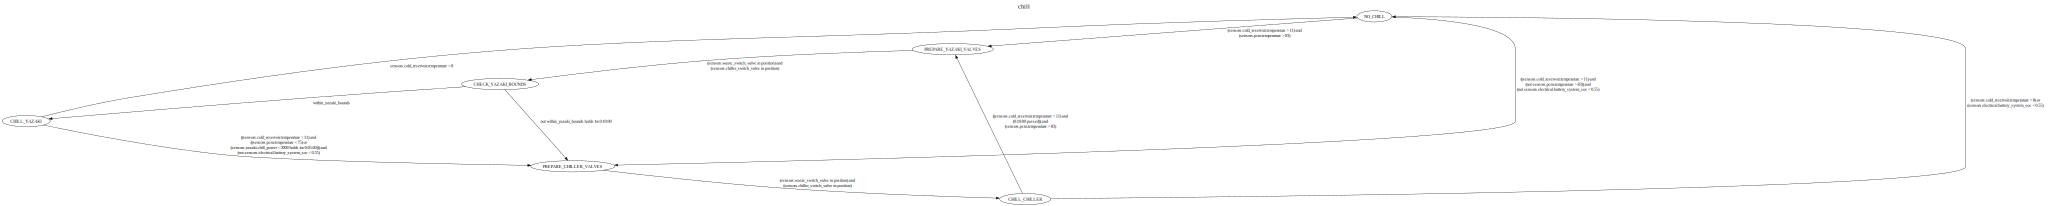

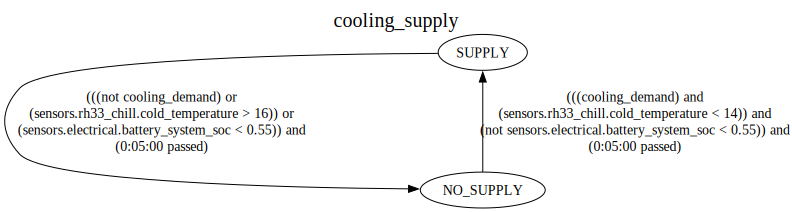

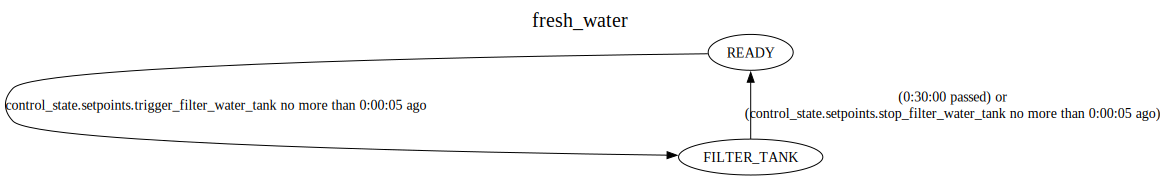

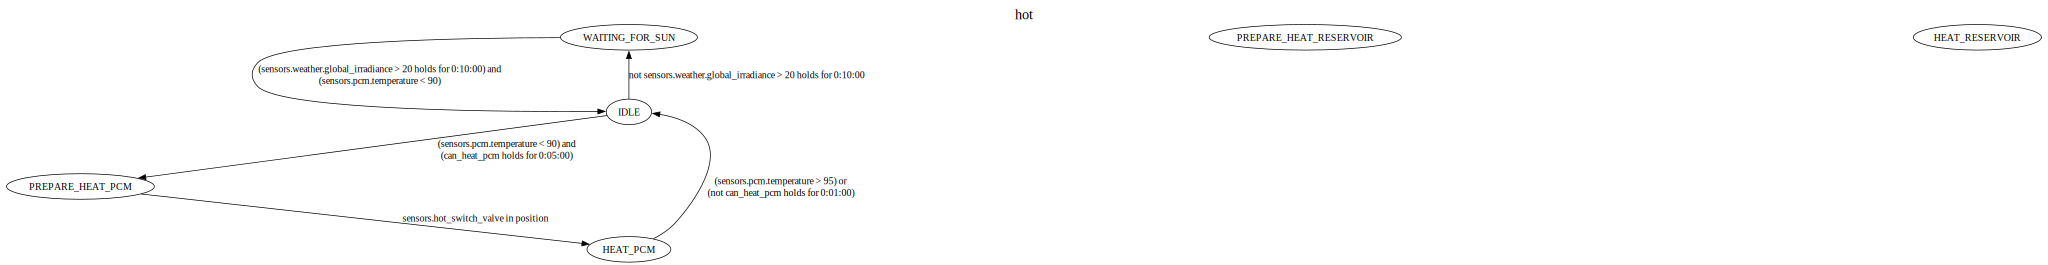

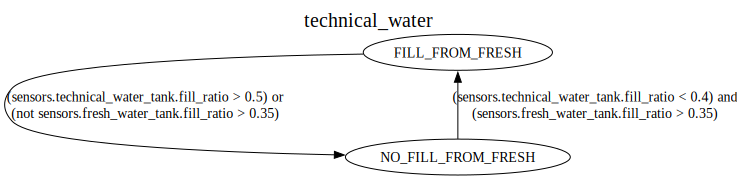

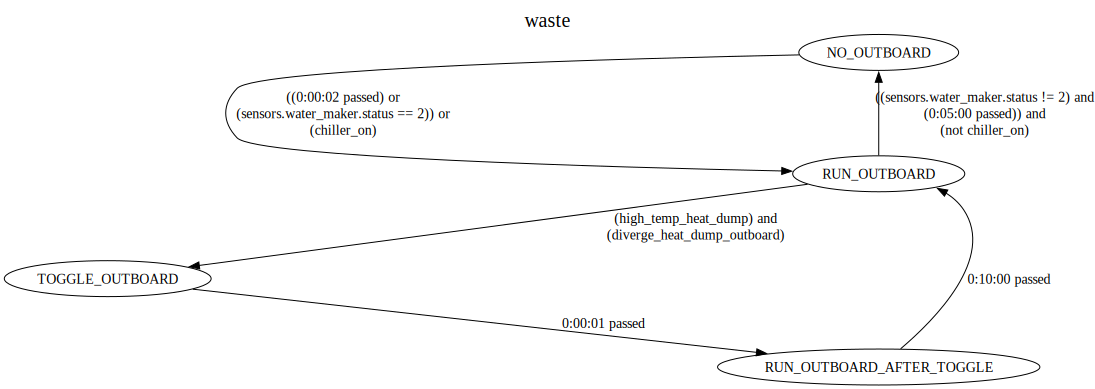

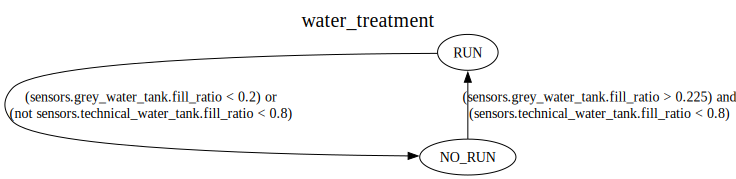

In [12]:
import importlib
import pkgutil
import energy_box_control.power_hub.control as ctrl

for module_info in pkgutil.iter_modules(ctrl.__path__, ""):
    try:
        module = importlib.import_module(
            f"energy_box_control.power_hub.control.{module_info.name}.control"
        )
        state_machine = getattr(
            module, next(val for val in dir(module) if val.endswith("_machine"))
        )
        graph = get_transitions(state_machine, module)
        result = draw(module_info.name, graph)
        display(result)
    except Exception as e:
        continue